In [1]:
import pandas_datareader.data as web
import datetime as dt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,7)

#!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
#Read CSV

df=pd.read_csv('cpi.csv',parse_dates=True,index_col=0)
 
df.head()

,CPI
DATE,
1990-01-01,127.5
1990-02-01,128.0
1990-03-01,128.6
1990-04-01,128.9
1990-05-01,129.1


In [3]:
df.describe()

,CPI
count,385.000000
mean,198.221665
std,40.704848
min,127.500000
25%,162.000000
50%,199.300000
75%,234.747000
max,281.933000


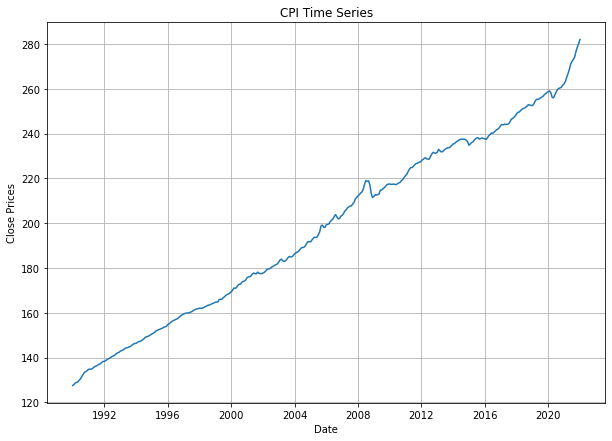

In [4]:
#plot close price
#plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['CPI'])
plt.title('CPI Time Series')
plt.show()

<AxesSubplot:ylabel='Density'>

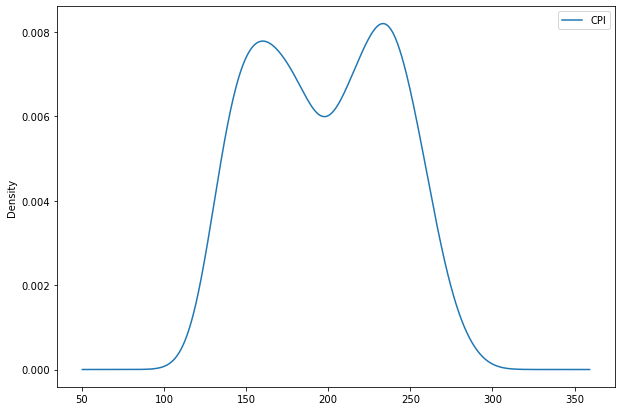

In [5]:
# Probability Distribution of the dataset
df_close = df['CPI']
df.plot(kind='kde')

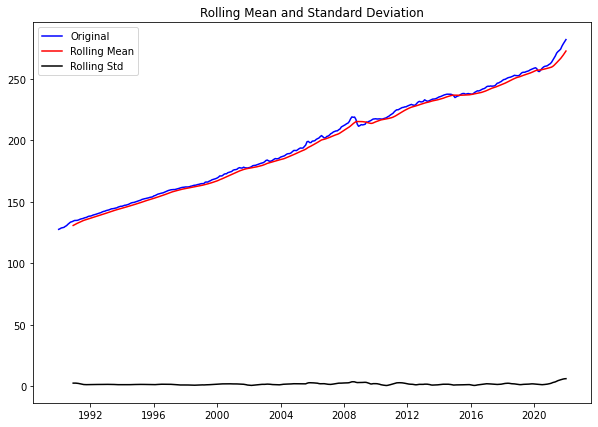

Results of dickey fuller test
Test Statistics                  1.411456
p-value                          0.997166
No. of lags used                15.000000
Number of observations used    369.000000
critical value (1%)             -3.448197
critical value (5%)             -2.869405
critical value (10%)            -2.570960
dtype: float64


In [6]:
#Test for staionarity The series becomes stationary if both the mean and standard deviation 
#are flat lines (constant mean and constant variance).

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)


#The increasing mean and standard deviation may be seen in the graph above, indicating that our series isn’t stationary.
#We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed 
#the critical values. As a result, the data is nonlinear.

{'adf': -2.7601718894578764,
 'pvalue': 0.06419199115834438,
 'usedlag': 14,
 'nobs': 369,
 'criticalvalues': {'1%': -3.448196541708585,
  '5%': -2.869404683789669,
  '10%': -2.5709597356805545},
 'icbest': 519.7327753590616}

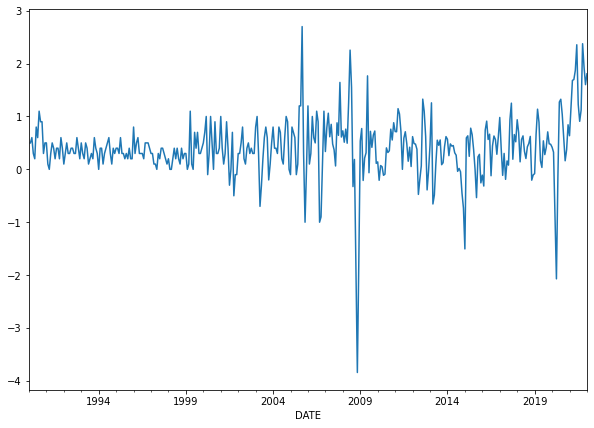

In [7]:
### Differencing the values converts the dataset from non-stationary to stationary. Goal P-value < .05
# Will be used to update d value in the p,d,q 

df['1difference']=df['CPI']-df['CPI'].shift(1)
 
df['1difference'].plot()

result=adfuller((df['1difference']).dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

<Figure size 720x504 with 0 Axes>

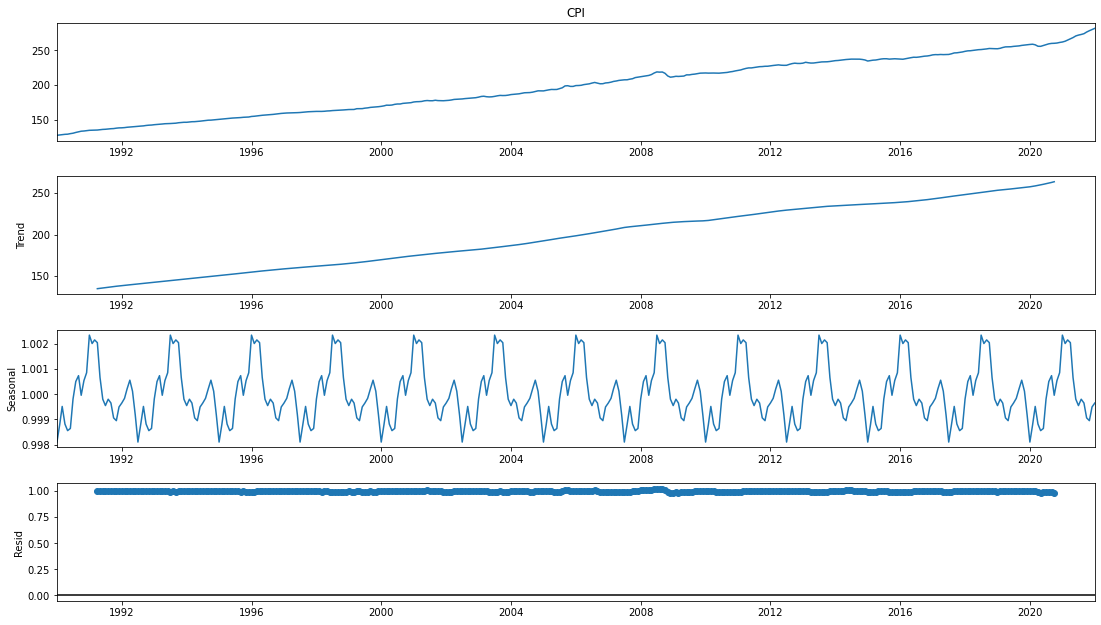

In [8]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


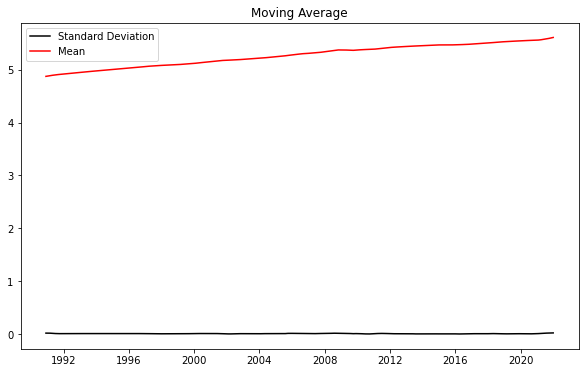

In [9]:
#To reduce the magnitude of the values and the growing trend in the series, we first take a log of the series. 
#We then calculate the rolling average of the series after obtaining the log of the series. A rolling average is 
#computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point 
#in the series.

#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

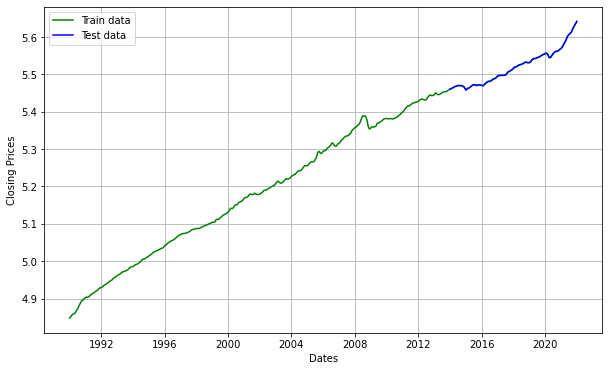

In [10]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.75)], df_log[int(len(df_close)*0.75):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2557.741, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2607.750, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2616.985, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2421.162, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2616.393, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2617.362, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2614.791, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2619.265, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2617.262, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-2553.048, Time=0.13 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 1.559 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  285
Model:               SARIMAX(0, 1, 3)   Log Likeliho

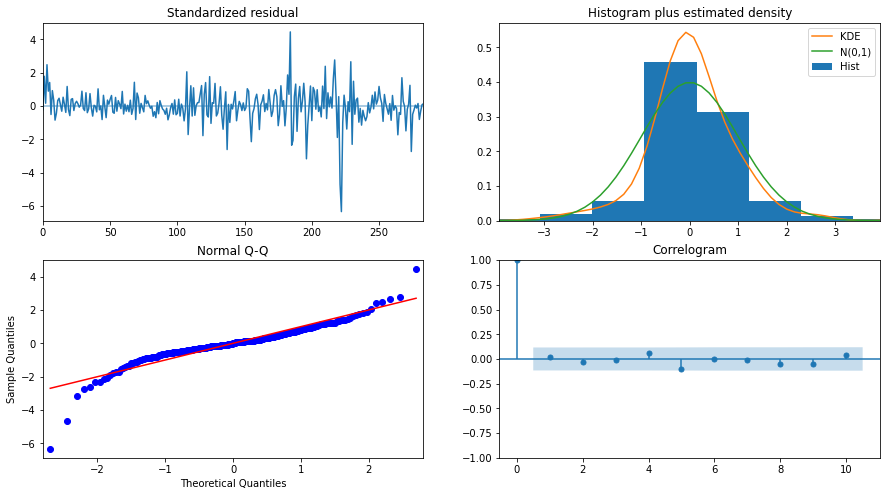

In [11]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [12]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(0,1,3))  
fitted = model.fit()  
print(fitted.summary())

/Users/bobbyatkins/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/bobbyatkins/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.63182D+00    |proj g|=  1.79815D-01

At iterate    5    f= -4.63182D+00    |proj g|=  4.05252D-02

At iterate   10    f= -4.63182D+00    |proj g|=  2.38148D-01

At iterate   15    f= -4.63182D+00    |proj g|=  7.21734D-04

At iterate   20    f= -4.63182D+00    |proj g|=  4.63015D-02

At iterate   25    f= -4.63182D+00    |proj g|=  4.81837D-04

At iterate   30    f= -4.63182D+00    |proj g|=  2.81588D-03

At iterate   35    f= -4.63182D+00    |proj g|=  4.52811D-03

At iterate   40    f= -4.63182D+00    |proj g|=  2.11386D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [15]:
# Forecast
fc, se, conf = fitted.forecast(97, alpha=0.05)

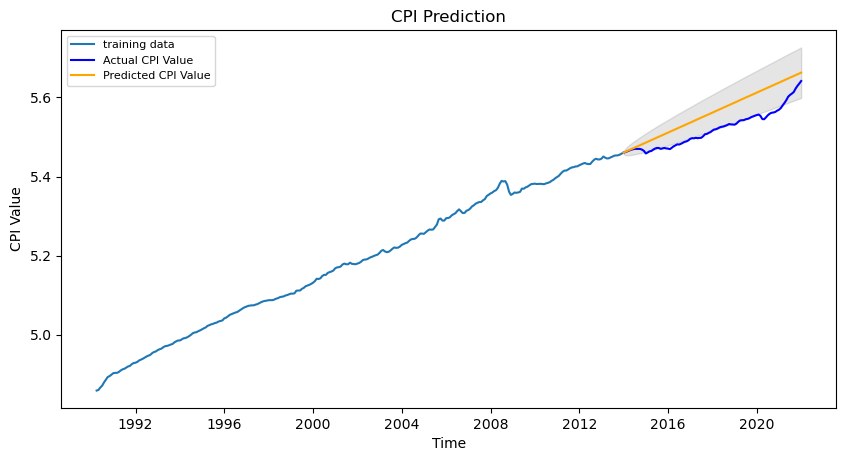

In [16]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual CPI Value')
plt.plot(fc_series, color = 'orange',label='Predicted CPI Value')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('CPI Prediction')
plt.xlabel('Time')
plt.ylabel('CPI Value')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Output to CSV
fc_series.to_csv('arima_inflation.csv')

In [17]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.00213142272613426
MAE: 0.04237009521021703
RMSE: 0.04616733397256398
MAPE: 0.007661845872998997
